# 🧠 Entrenamiento de Modelos Clásicos de Machine Learning

Este notebook entrena y compara modelos clásicos (SVM, Random Forest, KNN y MLP)  
utilizando las características de color y textura extraídas de las imágenes de hojas de papa.  
El objetivo es determinar qué modelo ofrece el mejor rendimiento en clasificación.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import joblib

# Ignorar warnings de convergencia de MLP para no saturar la salida
warnings.filterwarnings("ignore", category=UserWarning)

## 📂 1. Carga del dataset

Se carga el CSV generado en el notebook anterior con las características de las imágenes.  
Luego se inspeccionan las dimensiones y una muestra de los datos.


In [10]:
data_path = "../data/3_data_extract_features/features_dataset.csv"
df = pd.read_csv(data_path)
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (12304, 144)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f134,f135,f136,f137,f138,f139,f140,f141,f142,label
0,66.608757,118.838588,95.380712,50.503801,54.388886,56.084155,0.709024,0.264551,0.408486,-0.357151,...,0.480139,0.356773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bacteria
1,255.000000,255.000000,255.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,0.130702,0.080689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bacteria
2,65.542403,119.060494,95.172101,50.529366,54.456675,56.236278,0.817188,0.240932,0.425553,-0.119683,...,0.480139,0.356773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bacteria
3,68.384251,68.384251,68.384251,43.681501,43.681501,43.681501,1.035692,1.035692,1.035692,0.574811,...,0.373599,0.277572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bacteria
4,65.752993,139.603055,125.398704,53.922779,64.747192,65.821055,0.450341,0.022884,0.106899,-0.855384,...,0.786730,0.744599,2.0,4.0,8.0,8.0,64.0,16.0,0.0,Bacteria


## 🧮 2. Preparación de datos

En este paso:
- Se separan las características (X) de las etiquetas (y).  
- Se codifican las clases con `LabelEncoder`.  
- Se escalan los datos con `StandardScaler`.  
- Se dividen los datos en conjuntos de entrenamiento y prueba (80/20).


In [11]:
X = df.drop("label", axis=1)
y = df["label"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")
print("Clases:", list(encoder.classes_))

Entrenamiento: (9843, 143), Prueba: (2461, 143)
Clases: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


## ⚙️ 3. Definición de modelos clásicos

Se definen los clasificadores clásicos que se entrenarán y compararán:
- SVM
- Random Forest
- KNN
- MLP (red neuronal multicapa)


In [12]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=0.0005,  # regularización L2
        learning_rate_init=0.0005,
        max_iter=800,
        early_stopping=True,
        random_state=42
    )
}

param_grid_svm = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.01, 0.1],
    "kernel": ["rbf"]
}
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm,
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring="accuracy", n_jobs=-1)
grid_svm.fit(X_scaled, y_encoded)
best_svm = grid_svm.best_estimator_
print("Mejores parámetros SVM:", grid_svm.best_params_)
models["SVM"] = best_svm

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf,
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                       scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_scaled, y_encoded)
best_rf = grid_rf.best_estimator_
print("Mejores parámetros Random Forest:", grid_rf.best_params_)
models["Random Forest"] = best_rf

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1105, in check_array
    _assert_all_finite(
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


## 🚀 4. Entrenamiento y evaluación de modelos

Cada modelo se entrena con los datos de entrenamiento y se evalúa con el conjunto de prueba.  
Se calcula la exactitud (`accuracy`) y se muestra un reporte de clasificación detallado.

In [13]:
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=skf)
    cv_mean = cv_scores.mean()
    
    results.append({"Modelo": name, "Accuracy Test": acc_test, "CV Mean": cv_mean})
    
    print(f"🔹 Accuracy Test: {acc_test:.4f} | CV Mean: {cv_mean:.4f}")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
    print("-" * 60)

results_df = pd.DataFrame(results).sort_values(by="CV Mean", ascending=False)
results_df


Entrenando modelo: KNN


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 📊 5. Matriz de confusión del mejor modelo

Se visualiza la matriz de confusión del modelo con mejor rendimiento.


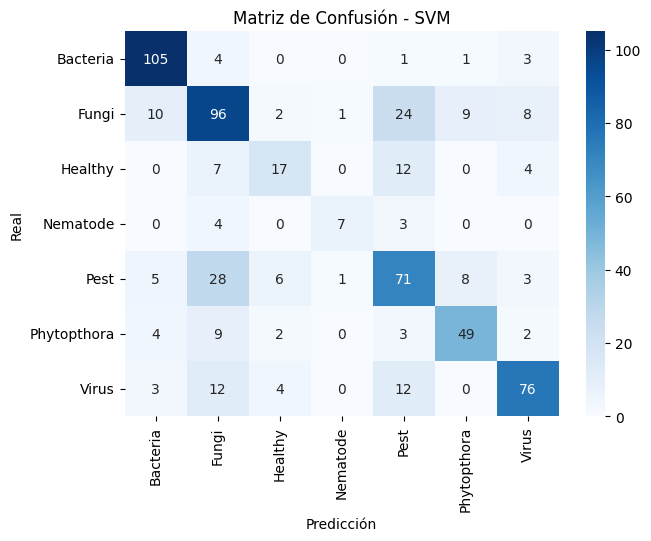

In [ ]:
best_model_name = results_df.iloc[0]["Modelo"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## 💾 6. Guardado del mejor modelo y objetos auxiliares

Se guarda el modelo con mejor desempeño junto al `LabelEncoder` y el `Scaler`  
para su uso posterior en la clasificación de nuevas imágenes.


In [ ]:
save_dir = "../models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_model, f"{save_dir}/best_model.pkl")
joblib.dump(encoder, f"{save_dir}/label_encoder.pkl")
joblib.dump(scaler, f"{save_dir}/scaler.pkl")

print(f"Modelo '{best_model_name}' guardado correctamente en {save_dir}/")

Modelo 'SVM' guardado correctamente en ../models/


## 📈 7. Comparación visual de modelos

Se muestra un gráfico de barras con la exactitud (`accuracy`) de cada modelo.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17980\895219086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Modelo", y="CV Mean", palette="viridis")


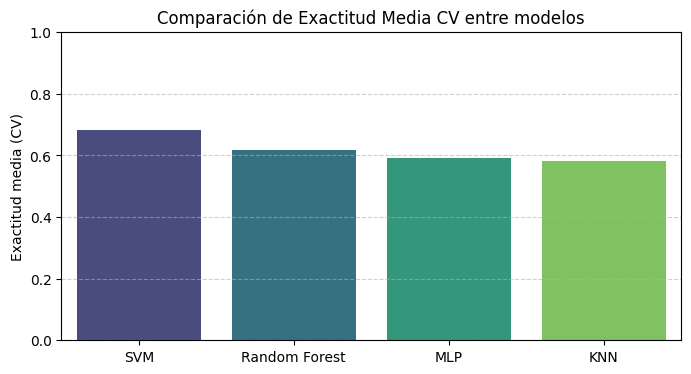

KNN: Test=0.589, CV=0.582
MLP: Test=0.586, CV=0.593
SVM: Test=0.683, CV=0.683
Random Forest: Test=0.583, CV=0.617


In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Modelo", y="CV Mean", palette="viridis")
plt.title("Comparación de Exactitud Media CV entre modelos")
plt.ylabel("Exactitud media (CV)")
plt.xlabel("")
plt.ylim(0,1)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()


# Comparar CV Mean vs Test Accuracy
for r in results:
    print(f"{r['Modelo']}: Test={r['Accuracy Test']:.3f}, CV={r['CV Mean']:.3f}")
